# Implementation and Evaluation of Metrics for Crash Point Determination for Aircraft Trajectory Risk Optimization (Code)

Note: The chapters mentioned in the notes below correspond to the chapters in the thesis

## 3.2.1 Development Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas as pd
import utm
from scipy import integrate

## Convert the latitude and longitude coordinates to X-Y coordinates. 
Only a rough conversion is done here. In actual applications, a more accurate conversion method may be required.

In [2]:
def ltln_to_xy(lt,ln):
    x = lt*110.574
    y = ln*np.cos(lt)*111.320
    return x,y

## 3.2.3 Implementation of Accident Models

In [3]:
def Ballistic_descent_model(m, g, rho, A, CD, y, vyi, vxi):
    vyih = np.maximum(0, vyi)
    
    c = 0.5*rho*A*CD
    Gamma = np.sqrt(m*g/c)
    gamma = 1/Gamma
    Hdh = np.arctanh(vyih*gamma)
    Huh = np.arctan(vyih*gamma)
    Gdh = np.log(np.cosh(Hdh))
    Guh = np.log(np.cosh(Huh))
    
    ttoph = -Gamma/g*np.arctan(gamma*np.minimum(0, vyi))

    x1 = m/c*np.log(1+vxi*c*ttoph/m)

    tch = m*(g*ttoph-Gamma*Hdh+vxi*(1+(Hdh-g*gamma*ttoph)**2))/(m*g+c*vxi*(g*ttoph-Gamma*Hdh))
    
    ytop = -m/(2*c)*np.log(1+(gamma*np.minimum(0,vyi)**2))

    tdroph = (np.arccosh(np.exp(c*(y-ytop)/m+Gdh))-Hdh)*(Gamma/g)

    timh = ttoph + tdroph

    vxtop = (m*vxi)/(m+vxi*c*ttoph)
    
    x2 = m/c*np.log(1+c*vxtop*(np.minimum(timh,tch)-ttoph)/m)

    vxc = (m*vxi)/(m+vxi*c*tch)
    vyc = Gamma*np.tanh(g*gamma*(tch-ttoph)+Hdh)
    
    Hc = np.arctanh(gamma*vyc)
    Gc = np.log(np.cosh(Hc))

    x3 = vxc*np.exp(Gc)*Gamma/g*(np.arctan(np.sinh(g*gamma*(timh-tch))+Hc)-np.arcsin(gamma*vyc))
    
    x = x1 + x2 + x3

    vxim = (m*vxi)/(m+vxi*c*timh) if timh <= tch else vxc*np.exp(Gc)/np.cosh(g*gamma*(timh-tch)+Hc)
    vyim = Gamma*np.tanh((g/Gamma)*(timh-ttoph)+Hdh)

    return x, timh, vxim, vyim

def Uncontrolled_glide_model(gamma, vg, y):
    x = gamma*y
    tdrop = x/vg
    vxim = vg
    vyim = y/tdrop
    return x, tdrop, vxim, vyim

def Parachute_descent_model(Ap, Cdp, m, g, y):
    x = 0
    vxim = 0
    vyim = np.sqrt(2*m*g/(Ap*Cdp))
    tdrop = y/vyim
    return x, tdrop, vxim, vyim

def Vim_angle_wind(vxim, vyim, w, theta, psi):
    v_ = np.sqrt(np.square(vxim) + np.square(w) - 2*vxim*w*np.cos(np.pi-np.abs(theta-psi)))
    return np.sqrt(np.square(v_)+np.square(vyim)), np.arctan(vyim/v_)
    
def Wind_frame(w, psi, theta_w, x, t):
    py = np.matrix([[np.cos(theta_w),-np.sin(theta_w)],[np.sin(theta_w), np.cos(theta_w)]])*np.matrix([[x],[0]])+w*np.matrix([[np.cos(psi)],[np.sin(psi)]])*t
    return py

def iintfp(theta, Rmax, vc):
    def f(pn, pe): return np.maximum(0, Rmax-np.linalg.norm([pn,pe])+np.cos(np.arctan(pn/pe)+theta)*np.linalg.norm([pn,pe])/vc)
    iintfp= integrate.dblquad(f, -np.inf, np.inf, -np.inf, np.inf)[0]
    return iintfp

def iintfp_polar(theta, Rmax, vc):
    def f(r, alpha): return np.maximum(0, Rmax-r+np.cos(alpha+theta)*r/vc)*r
    iintfp= integrate.dblquad(f, 0, 2*np.pi, 0, np.inf)[0]
    return iintfp

# return impact probobility in n x n m^2 area  
def Flyaway_model(theta, Rmax, vc, p, sigmava, iintfp):
    n = 10
    pn, pe = p[0], p[1]
    def f_(pn, pe): return np.maximum(0, Rmax-np.linalg.norm([pn,pe])+np.cos(np.arctan(pn/pe)+theta)*np.linalg.norm([pn,pe])/vc)/iintfp
    def g(pn, pe): return 1/(2*np.pi*np.square(sigmava))*np.exp(-np.square(np.linalg.norm([pn,pe]))/(2*np.square(sigmava)))
    iintf_ = integrate.dblquad(f_, pn, pn+n, pe, pe+n)[0]
    iintg = integrate.dblquad(g, pn, pn+n, pe, pe+n)[0]
    beta = 0.5
    return (1-beta)*iintf_ + beta*iintg
    
# return impact probobility in annulus area with width delta
def Flyaway_model_polar(theta, Rmax, vc, r, delta, sigmava, iintfp):
    def g(r,alpha): return 1/(2*np.pi*sigmava**2)*np.exp(-r**2/(2*sigmava**2))*r
    def f_(r,alpha): return np.maximum(0, Rmax-r+np.cos(alpha+theta)*r/vc)*r/iintfp
    iintf_ = integrate.dblquad(g, 0, 2*np.pi, r, r+delta)[0]
    iintg = integrate.dblquad(f_, 0, 2*np.pi, r, r+delta)[0]
    beta = 0.5
    return (1-beta)*iintf_+beta*iintg

## 3.2.7 Implementation of Casualty Estimation Model

In [4]:
def Casualty_estimation(Wua,Rp,Lua,Hp,gamma,p,m,vimp,alpha,beta,ps):
    Aexp = (Wua+2*Rp)*(Lua+Hp/np.tan(gamma)+2*Rp)
    Nexp = Aexp*p
    Eimp = 1/2*m*(vimp)**2
    Pfatality = 1/(1+(alpha/beta)**(1/2)*(beta/Eimp)**(1/(4*ps)))
    Nfatality = Nexp*Pfatality
    return Nfatality

## Table 3.1: Parameter settings for further research

In [5]:
# Random seed
np.random.seed(666)

# Mass
m = 3.75
# Gravity acceleration
g = 9.82
# Air density
rho = 1.3
# Frontal area
A = 0.1
# Parachute area
Ap = 12.5
# number of samples
n_samples = 100000
# Glide speed
vg = 16
# Wing span
Wua = 3.3 
# Length of the UAV
Lua = 2.3
# Radius of a person
Rp = 0.25
# Height of a person
Hp = 1.75

## 3.2.7 Implementation of Casualty Estimation Model

In [6]:
# Impact angle
im_a = np.pi/4
# Impact energy required for a fatality of pobability of 50% with ps = 0.5
alpha = 10**6
# Impact energy required to cause a fatality as ps goes to zero
beta = 100

## 2.5.4 Fly-away

In [7]:
# The maximum flight range given the avaliable fuel
Rmax = 1000
# The aircraft cruise airspeed
vc = 10
# The aircraft ascend more or less vertically with standard deviation 
sigmava = 10

# Cell size
cell_size = 10

## Select a Accident Model Type

In [8]:
# Accident model type: 'b' for Ballistic descent, 'p' for Parachute descent, 'u' for Uncontrolled glide, 'f' for Flyaway
type = 'b'

## Data cleaning and preprocessing

In [9]:
# convert lat,lon aircraft locations to x,y aircraft locations (utm standrad)
df=pd.read_csv('C:/Users/think/Desktop/StateDemo2.csv')
df_use = df.loc[:,['lat','lon','velocity','heading','vertrate','geoaltitude']]
df_use = df_use.loc[0:0]
for i,v in enumerate(df_use[['lat','lon']].values):
    df_use.iloc[i,:2] = utm.from_latlon(v[0],v[1])[:2]
df_use= df_use.rename(columns={'lat': 'x','lon': 'y'})
df_use[['x','y','velocity','geoaltitude']] = df_use[['x','y','velocity','geoaltitude']].div(10)

## Create lists to store data

In [10]:
impact_points = []
impact_points_x = []
impact_points_y = []
aircraft_path_x = []
aircraft_path_y = []

## Use model to calculate impact points and store in the list

In [11]:
if type == 'b':
    # Ballistic descent simulation
    # according to the aircraft path calculate the impact points
    for v in df_use.values:
        aircraft_path_x.append(v[0])
        aircraft_path_y.append(v[1])
        for n_sample in range(n_samples):
            vxi = v[2]*np.cos(-v[4]/180*np.pi)
            vyi = v[2]*np.sin(-v[4]/180*np.pi)

            # Drag coefficient at ballistic descent
            CD = np.abs(np.random.normal(0.7,0.2))
            # Wind speed
            w = np.random.normal(7,2)
            # Wind direction
            psi_mean = 1.24
            psi = np.random.normal(psi_mean,0.17)
            
            # Flight direction
            theta = v[3]/180*np.pi
            
            xtv = Ballistic_descent_model(m, g, rho, A, CD, v[5], vyi, vxi)
            temp = Wind_frame(w, psi, theta, xtv[0], xtv[1]).tolist()
            py = temp[1][0], temp[0][0]
            x_im, y_im = v[0]+py[0], v[1]+py[1]
            v_im, a_im = Vim_angle_wind(xtv[2], xtv[3], w, theta, psi)[0:2]
            
            # impact points with impact speed and impact angle
            impact_points.append([x_im,y_im,v_im,a_im])
            impact_points_x.append(x_im)
            impact_points_y.append(y_im)  
            
elif type == 'p':
    # Parachute descent simulation
    # according to the aircraft path calculate the impact points
    for v in df_use.values:
        aircraft_path_x.append(v[0])
        aircraft_path_y.append(v[1])
        for n_sample in range(n_samples):
            vxi = v[2]*np.cos(-v[4]/180*np.pi)
            vyi = v[2]*np.sin(-v[4]/180*np.pi)

            # Drag coefficient at parachute descent
            Cdp = np.abs(np.random.normal(1.14,0.2))
            # Wind speed
            w = np.random.normal(7,2)
            # Wind direction
            psi_mean = 1.24
            psi = np.random.normal(psi_mean,0.17)

            # Flight direction
            theta = v[3]/180*np.pi
            
            xtv = Parachute_descent_model(Ap, Cdp, m, g, v[5])
            temp = Wind_frame(w, psi, theta, xtv[0], xtv[1]).tolist()
            py = temp[1][0], temp[0][0]
            x_im, y_im = v[0]+py[0], v[1]+py[1]
            v_im, a_im = Vim_angle_wind(xtv[2], xtv[3], w, theta, psi)[0:2]
            
            # impact points with impact speed and impact angle
            impact_points.append([x_im,y_im,v_im,a_im])
            impact_points_x.append(x_im)
            impact_points_y.append(y_im)  
            
elif type == 'u':            
    # Uncontrolled glide simulation
    # according to the aircraft path calculate the impact points
    for v in df_use.values:
        aircraft_path_x.append(v[0])
        aircraft_path_y.append(v[1])
        for n_sample in range(n_samples):
            
            vxi = v[2]*np.cos(-v[4]/180*np.pi)
            vyi = v[2]*np.sin(-v[4]/180*np.pi)

            # Glide ratio at uncontrolled glide
            gamma = np.abs(np.random.normal(12,2))
            # Wind speed
            w = np.random.normal(7,2)
            # Wind direction
            psi_mean = 1.54
            psi = np.random.normal(psi_mean,0.17)
            
            # Flight direction
            theta = v[3]/180*np.pi
            
            xtv = Uncontrolled_glide_model(gamma, vg, v[5])
            temp = Wind_frame(w, psi, theta, xtv[0], xtv[1]).tolist()
            py = temp[1][0], temp[0][0]
            x_im, y_im = v[0]+py[0], v[1]+py[1]
            
            v_im, a_im = Vim_angle_wind(xtv[2], xtv[3], w, theta, psi)[0:2]
            
            # impact points with impact speed and impact angle
            impact_points.append([x_im,y_im,v_im,a_im])
            impact_points_x.append(x_im)
            impact_points_y.append(y_im)

## Draw the heat map based on impact points
Note: In order to simplify the test, the impact points here are only distributed in the northeast direction of the aircraft position. All directions should be considered in actual applications, otherwise an error will be reported

In [12]:
if type != 'f':
    # Set heatmap size, where each cell of heatmap is cell_size x cell_size m^2
    max_x, min_x = max(impact_points_x + aircraft_path_x), min(impact_points_x + aircraft_path_x)
    max_y, min_y = max(impact_points_y + aircraft_path_y), min(impact_points_y + aircraft_path_y)
    x_length = int((max_x-min_x)//cell_size+1)
    y_length = int((max_y-min_y)//cell_size+1)
    heatmap_data = np.zeros((y_length+1, x_length+1))
#     # Set no-fly zone
#     no_fly_zone = []
#     for x in range(int((x_length+1)/10)):
#         for y in range(int((y_length+1)/10)):
#             no_fly_zone.append([x,y])
    # Set population density map with the same size as the heatmap size
    populationmap_data = np.full((y_length+1, x_length+1),232)
    # Set schelter map with the same size as the heatmap size
    sheltermap_data = np.full((y_length+1, x_length+1),0.5)
    
elif type == 'f':
    # load aircraft path loactions
    for v in df_use.values: 
        aircraft_path_x.append(v[0])
        aircraft_path_y.append(v[1]) 
    # Set heatmap size, where each cell of heatmap is cell_size x cell_size m^2 
    max_x, min_x = max(aircraft_path_x)+Rmax, min(aircraft_path_x)-Rmax
    max_y, min_y = max(aircraft_path_y)+Rmax, min(aircraft_path_y)-Rmax
    x_length = int((max_x-min_x)//cell_size+1)
    y_length = int((max_y-min_y)//cell_size+1)
    heatmap_data = np.zeros((y_length+1, x_length+1))
    # Set population density map with the same size as the heatmap size
    populationmap_data = np.full((y_length+1, x_length+1),232)
    # Set schelter map with the same size as the heatmap size
    sheltermap_data = np.full((y_length+1, x_length+1),0.5)

## Create population density maps and shadow maps if necessary. 
Note: Here is omitted to simplify the test

In [13]:
# # Set population density map values

# # number of random centers
# n_centers = 10
# # covariance matrix
# cov = np.array([[10000/cell_size,0],
#               [0,10000/cell_size]])
# mus = np.random.uniform(0, max(x_length,y_length), size=(n_centers, 2))
# # number of dense population points
# n_dense = int(500000/cell_size)
# dense_points = np.zeros((n_dense, 2))

# for i in range(n_dense):
#     # choose a center randomly
#     j = int(np.random.uniform(0, n_centers, size=(1, 1)))
#     mu = mus[j]
#     # create densely populated area from gauss
#     dense_points[i] = np.random.multivariate_normal(mu, cov, 1)
# # Set population density values of densely populated area
# for point in dense_points:
#     if int(point[0]) > 0 and int(point[0]) < y_length and int(point[1]) > 0 and int(point[1]) < x_length:
#         populationmap_data[int(point[0])][int(point[1])]+= 0.0001 

In [14]:
# # Set shelter map values

# # number of random centers
# n_centers = 10
# # covariance matrix
# cov = np.array([[10000/cell_size,0],
#               [0,10000/cell_size]])
# mus = np.random.uniform(0, max(x_length,y_length), size=(n_centers, 2))
# # number of well sheltered points
# n_sheltered = int(500000/cell_size)
# # well sheltered points
# sheltered_points = np.zeros((n_sheltered, 2))

# for i in range(n_sheltered):
#     # choose a center randomly
#     j = int(np.random.uniform(0, n_centers, size=(1, 1)))
#     mu = mus[j]
#     # create well sheltered area from gauss
#     sheltered_points[i] = np.random.multivariate_normal(mu, cov, 1)
# # Set well sheltered area with sheltering parametr 0.75

# for point in sheltered_points:
#     if int(point[0]) > 0 and int(point[0]) < y_length and int(point[1]) > 0 and int(point[1]) < x_length:
#         sheltermap_data[int(point[0])][int(point[1])]=0.75

## Map aircraft path in heatmap

In [15]:
# Map aircraft path in heatmap:
if type != 'f':
    for i,point_x in enumerate(aircraft_path_x):
        aircraft_path_x[i] = (point_x-min_x)/cell_size
    for i,point_y in enumerate(aircraft_path_y):
        aircraft_path_y[i] = (point_y-min_y)/cell_size 
        
elif type == 'f':
    for i,point_x in enumerate(aircraft_path_x):
        aircraft_path_x[i] = (point_x-min_x)/cell_size
    for i,point_y in enumerate(aircraft_path_y):
        aircraft_path_y[i] = (point_y-min_y)/cell_size
    Rmax = Rmax/cell_size

## Set heatmap values

In [16]:
# Map impact points to heatmap points and set heatmap values
# for point in no_fly_zone:
#     heatmap_data[point[0]][point[1]] = -1/n_samples
sum_risk = 0
if type != 'f':
    for point in impact_points:
        heatmap_x = int((point[0]-min_x)//cell_size+1)
        heatmap_y = int((point[1]-min_y)//cell_size+1)
        risk = 10e-6*(1/len(df_use.values))*(1/n_samples)*Casualty_estimation(Wua,Rp,Lua,Hp,point[3],
        populationmap_data[heatmap_y][heatmap_x],m,point[2],alpha,beta,sheltermap_data[heatmap_y][heatmap_x]) 
        heatmap_data[heatmap_y][heatmap_x] += risk
        sum_risk += risk
elif type == 'f':
    # wind average direction
    psi_mean = 1.24
    iintfp = iintfp_polar(psi_mean, Rmax, vc) 
    for i in range(len(aircraft_path_x)):
        # Calculate candidates of impact points: 
        candidates_impact_points = []
        # Impact points are all the points in All points in a circle centered on a point on the flight path and Rmax is the radius
        for x in range(int(aircraft_path_x[i]-Rmax), int(aircraft_path_x[i]+Rmax)):
            for y in range(int(aircraft_path_y[i]-Rmax), int(aircraft_path_y[i]+Rmax)):
                if np.linalg.norm(np.array([x,y])-np.array([aircraft_path_x[i], aircraft_path_y[i]]))<=Rmax:
                    candidates_impact_points.append([x,y])
        # Step width
        delta = 4              
        # Set risk value of impact points
        for r in range(0, int(Rmax), delta):
            impact_points = []
            v = Flyaway_model_polar(psi_mean, Rmax, vc, r, delta, sigmava, iintfp)
            for j,point in enumerate(candidates_impact_points):
                if np.linalg.norm(np.array(point)-np.array([aircraft_path_x[i], aircraft_path_y[i]]))<=r:
                    impact_points.append([point[0],point[1]])
                    del candidates_impact_points[j]
            for point in impact_points:
                    heatmap_data[point[1]][point[0]] = 10e-6*v*Casualty_estimation(Wua,Rp,Lua,Hp,im_a,
        populationmap_data[point[1]][point[0]],m,vc,alpha,beta,sheltermap_data[point[1]][point[0]])

## Draw population density maps and shadow maps if necessary. 
Note: Here is omitted to simplify the test

In [17]:
# # draw population density map
# # plt.figure(figsize=(30,30))
# heatmap = plt.imshow(populationmap_data, cmap='rainbow', origin='lower',extent = [0 , x_length*cell_size, 0 , y_length*cell_size])
# colorbar = plt.colorbar(heatmap)
# colorbar.set_label('population density')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# # plt.plot(aircraft_path_x,aircraft_path_y,color='black')
# # plt.gca().invert_yaxis()

In [18]:
# # draw shelter map
# # plt.figure(figsize=(30,30))
# # plt.xticks(x_ticks)
# # plt.yticks(y_ticks)
# heatmap = plt.imshow(sheltermap_data, cmap='rainbow', origin='lower',extent = [0 , x_length*cell_size, 0 , y_length*cell_size])
# colorbar = plt.colorbar(heatmap)
# colorbar.set_label('sheltering parameter')
# plt.xlabel('x (m)')
# plt.ylabel('y (m)')
# # plt.plot(aircraft_path_x,aircraft_path_y,color='black')
# # plt.gca().invert_yaxis()

## Draw heat map

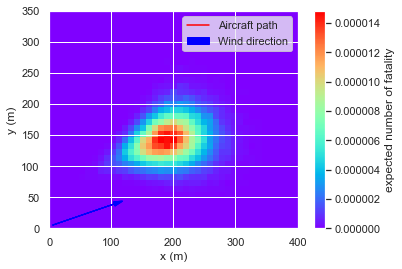

In [19]:
# draw heat map
# plt.figure(figsize=(10,10))
m = min(x_length,y_length)*cell_size
a0, = plt.plot([x*cell_size for x in aircraft_path_x],[y*cell_size for y in aircraft_path_y],color='red')
a2 = plt.arrow(aircraft_path_x[0]*cell_size, aircraft_path_y[0]*cell_size, 0.3*m*np.sin(psi_mean), 0.3*m*np.cos(psi_mean), 
               head_width=0.02*m, head_length=0.04*m, color = 'blue')
a2 = plt.arrow(aircraft_path_x[len(aircraft_path_x)//2-1]*cell_size, aircraft_path_y[len(aircraft_path_y)//2-1]*cell_size, 0.3*m*np.sin(psi_mean), 0.3*m*np.cos(psi_mean), 
               head_width=0.02*m, head_length=0.04*m, color = 'blue')
a2 = plt.arrow(aircraft_path_x[-1]*cell_size, aircraft_path_y[-1]*cell_size, 0.3*m*np.sin(psi_mean), 0.3*m*np.cos(psi_mean), 
               head_width=0.02*m, head_length=0.04*m, color = 'blue')
heatmap = plt.imshow(heatmap_data, cmap='rainbow', origin='lower',extent = [0 , x_length*cell_size, 0 , y_length*cell_size])
colorbar = plt.colorbar(heatmap)
colorbar.set_label('expected number of fatality')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(handles = [a0, a2], labels = ['Aircraft path','Wind direction'], loc = 'best')